## from https://web.stanford.edu/~boyd/papers/admm/

# Code

In [1]:
code = grabcode("https://web.stanford.edu/~boyd/papers/admm/nonconvex/regressor_sel.html")


code =

    'function [z, history] = regressor_sel(A, b, K, rho)
     % regressor_sel  Solve lasso problem via ADMM
     %
     % [x, history] = regressor_sel(A, b, K, rho, alpha)
     % 
     % Attempts to solve the following problem via ADMM:
     %
     %   minimize || Ax - b ||_2^2
     %   subject to card(x) <= K
     %
     % where card() is the number of nonzero entries. 
     %
     % The solution is returned in the vector x.
     %
     % history is a structure that contains the objective value, the primal and 
     % dual residual norms, and the tolerances for the primal and dual residual 
     % norms at each iteration.
     % 
     % rho is the augmented Lagrangian parameter. 
     %
     % alpha is the over-relaxation parameter (typical values for alpha are 
     % between 1.0 and 1.8).
     %
     %
     % More information can be found in the paper linked at:
     % http://www.stanford.edu/~boyd/papers/distr_opt_stat_learning_admm.html
     %
     
     
     t_start = t

In [2]:
%%file regressor_sel.m

function [z, history] = regressor_sel(A, b, K, rho)
% regressor_sel  Solve lasso problem via ADMM
%
% [x, history] = regressor_sel(A, b, K, rho, alpha)
%
% Attempts to solve the following problem via ADMM:
%
%   minimize || Ax - b ||_2^2
%   subject to card(x) <= K
%
% where card() is the number of nonzero entries.
%
% The solution is returned in the vector x.
%
% history is a structure that contains the objective value, the primal and
% dual residual norms, and the tolerances for the primal and dual residual
% norms at each iteration.
%
% rho is the augmented Lagrangian parameter.
%
% alpha is the over-relaxation parameter (typical values for alpha are
% between 1.0 and 1.8).
%
%
% More information can be found in the paper linked at:
% http://www.stanford.edu/~boyd/papers/distr_opt_stat_learning_admm.html
%


t_start = tic;

%% Global constants and defaults

QUIET    = 0;
MAX_ITER = 1000;
ABSTOL   = 1e-4;
RELTOL   = 1e-2;

%% Data preprocessing

[m, n] = size(A);

% save a matrix-vector multiply
Atb = A'*b;

%% ADMM solver

x = zeros(n,1);
z = zeros(n,1);
u = zeros(n,1);

% cache the factorization
[L U] = factor(A, rho);

if ~QUIET
    fprintf('%3s\t%10s\t%10s\t%10s\t%10s\t%10s\n', 'iter', ...
      'r norm', 'eps pri', 's norm', 'eps dual', 'objective');
end

for k = 1:MAX_ITER

    % x-update
    q = Atb + rho*(z - u);    % temporary value
    if( m >= n )    % if skinny
       x = U \ (L \ q);
    else            % if fat
       x = q/rho - (A'*(U \ ( L \ (A*q) )))/rho^2;
    end

    % z-update with relaxation
    zold = z;
    z = keep_largest(x + u, K);

    % u-update
    u = u + (x - z);

    % diagnostics, reporting, termination checks
    history.objval(k)  = objective(A, b, x);

    history.r_norm(k)  = norm(x - z);
    history.s_norm(k)  = norm(-rho*(z - zold));

    history.eps_pri(k) = sqrt(n)*ABSTOL + RELTOL*max(norm(x), norm(-z));
    history.eps_dual(k)= sqrt(n)*ABSTOL + RELTOL*norm(rho*u);

    if ~QUIET
        fprintf('%3d\t%10.4f\t%10.4f\t%10.4f\t%10.4f\t%10.2f\n', k, ...
            history.r_norm(k), history.eps_pri(k), ...
            history.s_norm(k), history.eps_dual(k), history.objval(k));
    end

    if (history.r_norm(k) < history.eps_pri(k) && ...
       history.s_norm(k) < history.eps_dual(k))
         break;
    end

end

if ~QUIET
    toc(t_start);
end
end

function p = objective(A, b, x)
    p = sum_square(A*x - b);
end

function z = keep_largest(z, K)
    [val pos] = sort(abs(z), 'descend');
    z(pos(K+1:end)) = 0;
end

function [L U] = factor(A, rho)
    [m, n] = size(A);
    if ( m >= n )    % if skinny
       L = chol( A'*A + rho*speye(n), 'lower' );
    else            % if fat
       L = chol( speye(m) + 1/rho*(A*A'), 'lower' );
    end

    % force matlab to recognize the upper / lower triangular structure
    L = sparse(L);
    U = sparse(L');
end

Created file '/home/wenh06/Jupyter/wenhao/workspace/fl_seminar/code/boyd-admm/regressor_sel.m'.


# Example

In [3]:
eg_code = grabcode("https://web.stanford.edu/~boyd/papers/admm/nonconvex/regressor_sel_example.html")


eg_code =

    '% Cardinality constrained least-squares example (nonconvex)
     
     %% Generate problem data
     
     randn('seed', 0);
     rand('seed',0);
     
     m = 1500;       % number of examples
     n = 5000;       % number of features
     p = 100/n;      % sparsity density  
     
     % generate sparse solution vector
     x = sprandn(n,1,p);
     
     % generate random data matrix
     A = randn(m,n);
     
     % normalize columns of A
     A = A*spdiags(1./sqrt(sum(A.^2))', 0, n, n);
     
     % generate measurement b with noise
     b = A*x + sqrt(0.001)*randn(m,1);
     
     xtrue = x;   % save solution
     
     %% Solve problem
     
     [x history] = regressor_sel(A, b, p*n, 1.0);
     
     %% Reporting
     K = length(history.objval);                                                                                                        
     
     h = figure;
     plot(1:K, history.objval, 'k', 'MarkerSize', 10, 'LineWidth', 2); 
     ylabel('f(x^k) +

### Generate problem data

In [4]:
randn('seed', 0);
rand('seed',0);

m = 1500;       % number of examples
n = 5000;       % number of features
p = 100/n;      % sparsity density

% generate sparse solution vector
x = sprandn(n,1,p);

% generate random data matrix
A = randn(m,n);

% normalize columns of A
A = A*spdiags(1./sqrt(sum(A.^2))', 0, n, n);

% generate measurement b with noise
b = A*x + sqrt(0.001)*randn(m,1);

xtrue = x;   % save solution

### Solve problem

In [5]:
[x history] = regressor_sel(A, b, p*n, 1.0);

iter	    r norm	   eps pri	    s norm	  eps dual	 objective
  1	    3.1818	    0.0465	    2.3330	    0.0389	      5.38
  2	    1.1927	    0.0585	    2.6814	    0.0487	      7.92
  3	    1.1216	    0.0790	    2.2545	    0.0485	      6.72
  4	    1.2543	    0.0934	    1.7125	    0.0446	      4.94
  5	    1.3137	    0.1020	    1.4387	    0.0400	      3.57
  6	    1.2244	    0.1070	    1.1351	    0.0349	      2.49
  7	    1.0563	    0.1093	    0.8049	    0.0304	      1.77
  8	    0.8269	    0.1095	    0.4945	    0.0276	      1.40
  9	    0.5639	    0.1085	    0.2625	    0.0265	      1.29
 10	    0.3841	    0.1069	    0.2960	    0.0263	      1.28
 11	    0.3259	    0.1054	    0.3102	    0.0264	      1.28
 12	    0.2956	    0.1041	    0.2813	    0.0263	      1.26
 13	    0.3156	    0.1032	    0.2956	    0.0263	      1.25
 14	    0.2677	    0.1027	    0.1912	    0.0263	      1.23
 15	    0.2134	    0.1025	    0.1609	    0.0263	      1.24
 16	    0.1605	    0.1025	    0.0817	    0.0264	      1

### Reporting

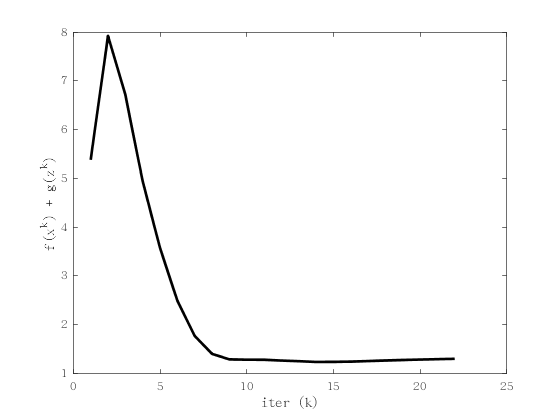

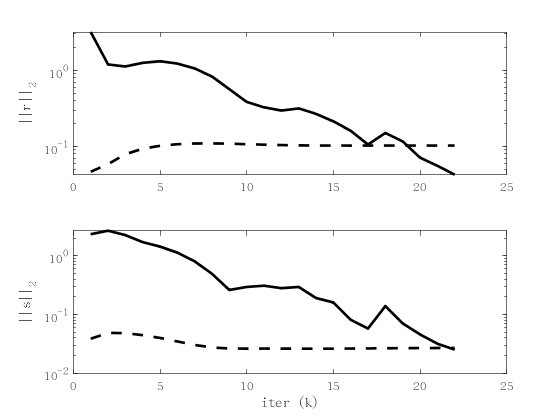

In [6]:
K = length(history.objval);

h = figure;
plot(1:K, history.objval, 'k', 'MarkerSize', 10, 'LineWidth', 2);
ylabel('f(x^k) + g(z^k)'); xlabel('iter (k)');

g = figure;
subplot(2,1,1);
semilogy(1:K, max(1e-8, history.r_norm), 'k', ...
    1:K, history.eps_pri, 'k--',  'LineWidth', 2);
ylabel('||r||_2');

subplot(2,1,2);
semilogy(1:K, max(1e-8, history.s_norm), 'k', ...
    1:K, history.eps_dual, 'k--', 'LineWidth', 2);
ylabel('||s||_2'); xlabel('iter (k)');